In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, recall_score, f1_score, 
                             confusion_matrix, precision_score, roc_auc_score,
                             classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler


In [4]:
plt.style.use('ggplot')
sns.set_palette('viridis')
pd.set_option('display.max_columns', 50)
nlp = spacy.load('en_core_web_sm')

In [5]:
#%% Data Loading & Initial Inspection
df = pd.read_csv('fake_job_postings.csv')
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
display(df.head())

Dataset Shape: (17880, 18)

First 5 Rows:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


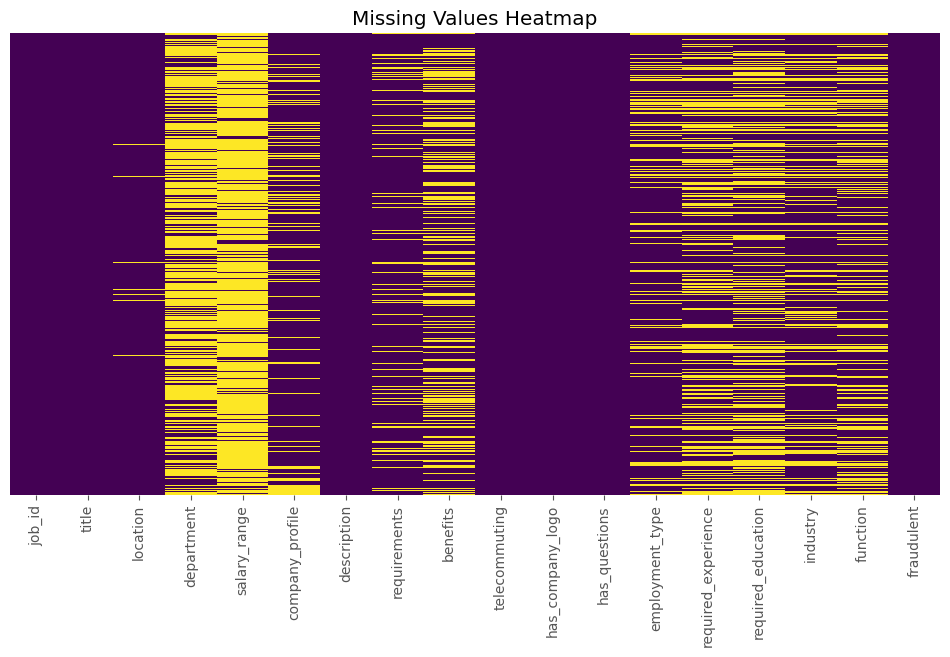

In [6]:
# Missing Data Analysis
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

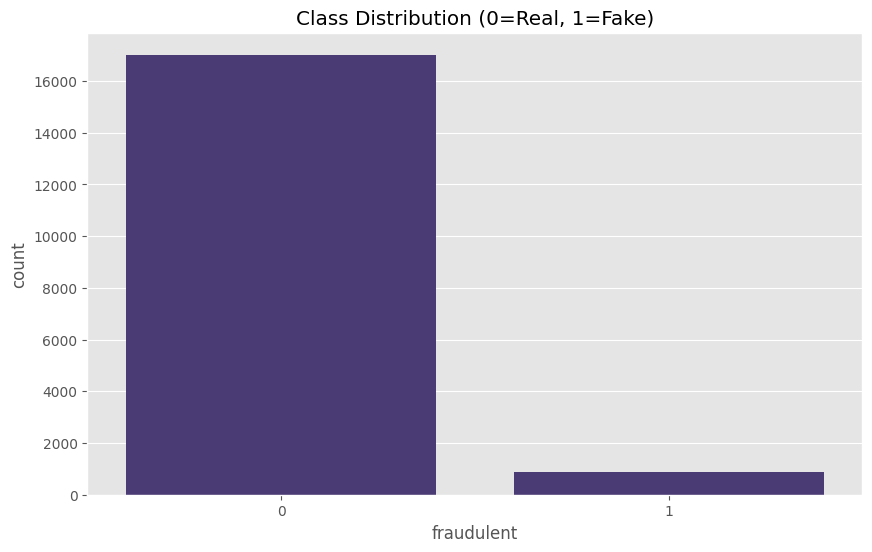

In [7]:
# Target Distribution
plt.figure(figsize=(10,6))
sns.countplot(x='fraudulent', data=df)
plt.title('Class Distribution (0=Real, 1=Fake)')
plt.show()

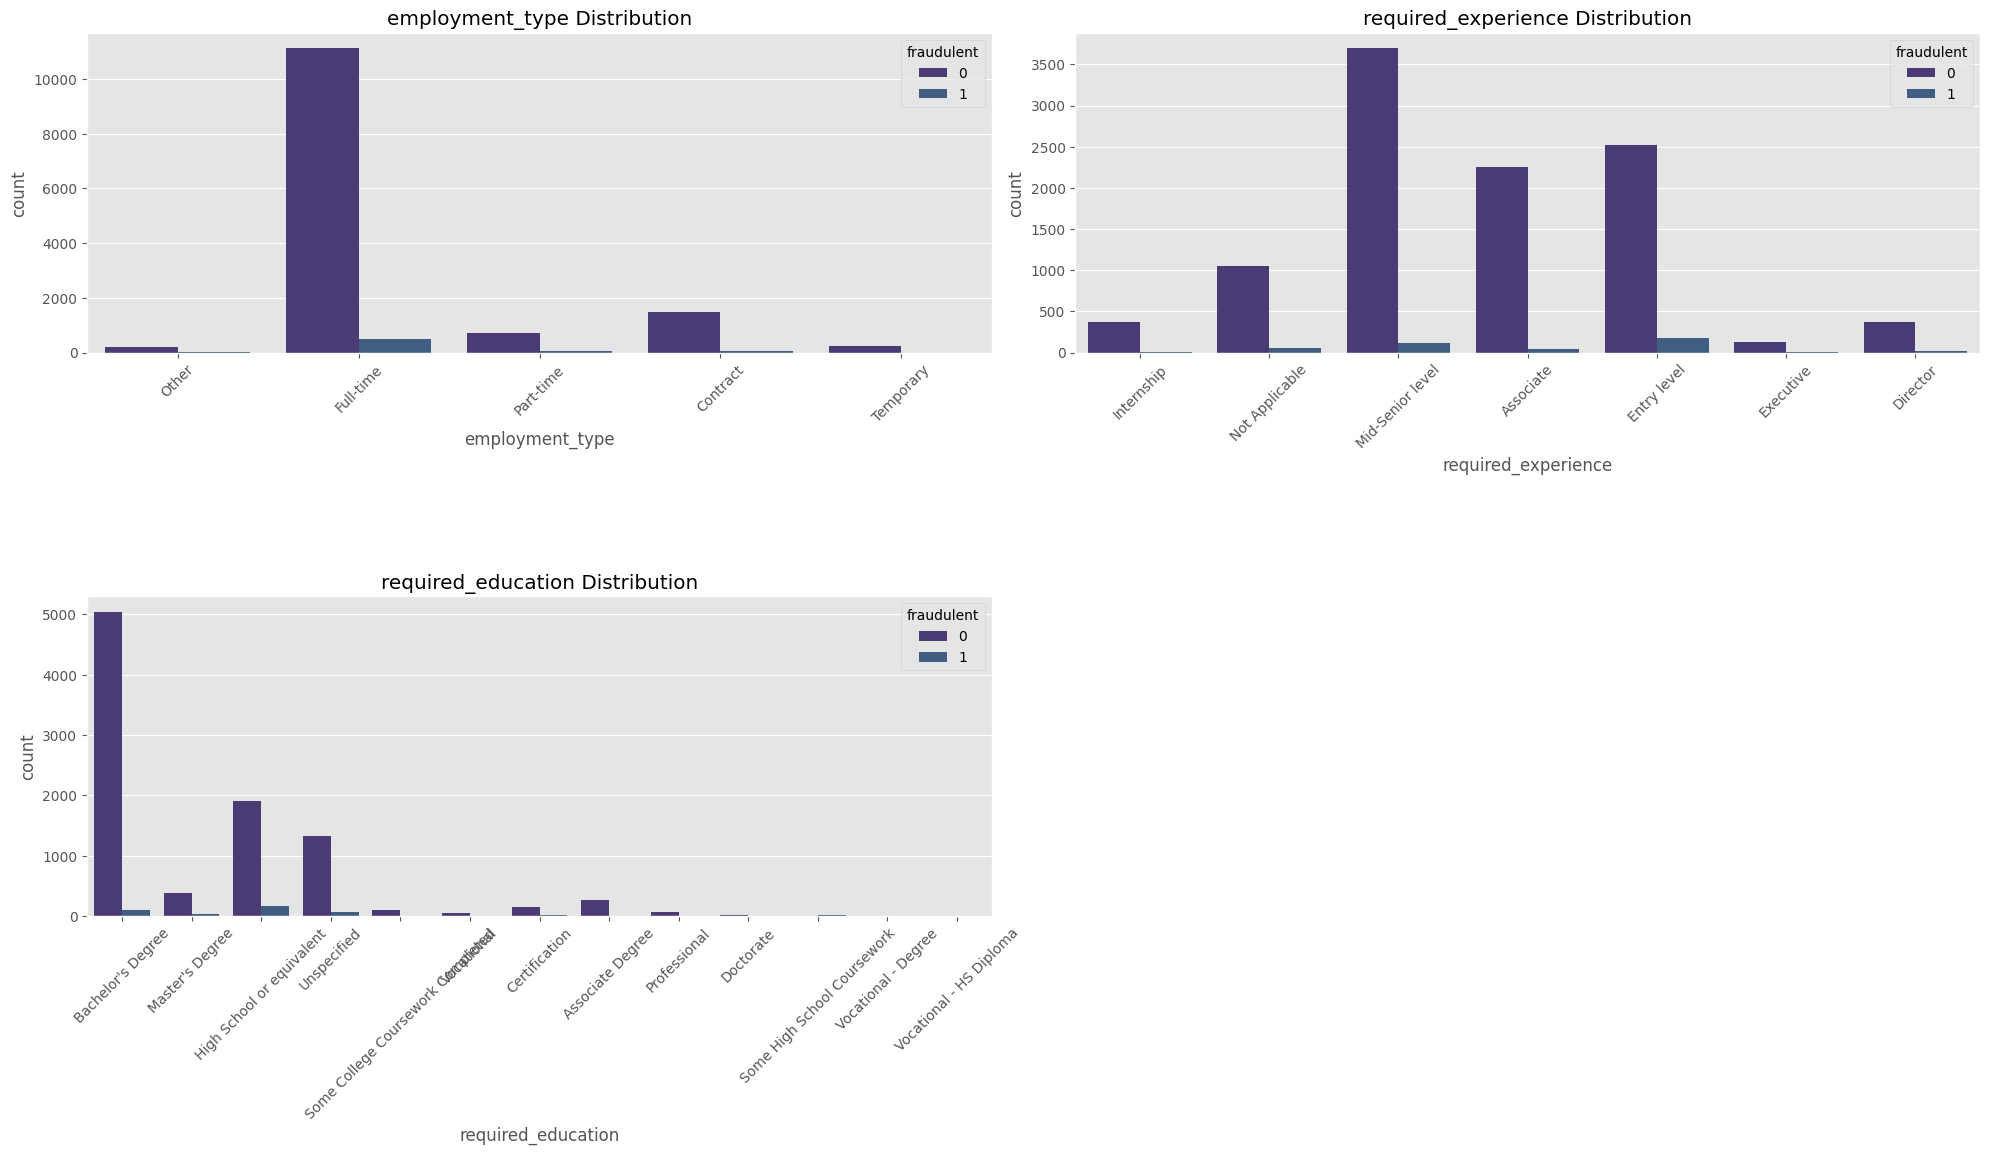

In [8]:
# Categorical Features Analysis
cat_cols = ['employment_type', 'required_experience', 'required_education']
plt.figure(figsize=(20,15))
for i,col in enumerate(cat_cols,1):
    plt.subplot(3,2,i)
    sns.countplot(x=col, data=df, hue='fraudulent')
    plt.xticks(rotation=45)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

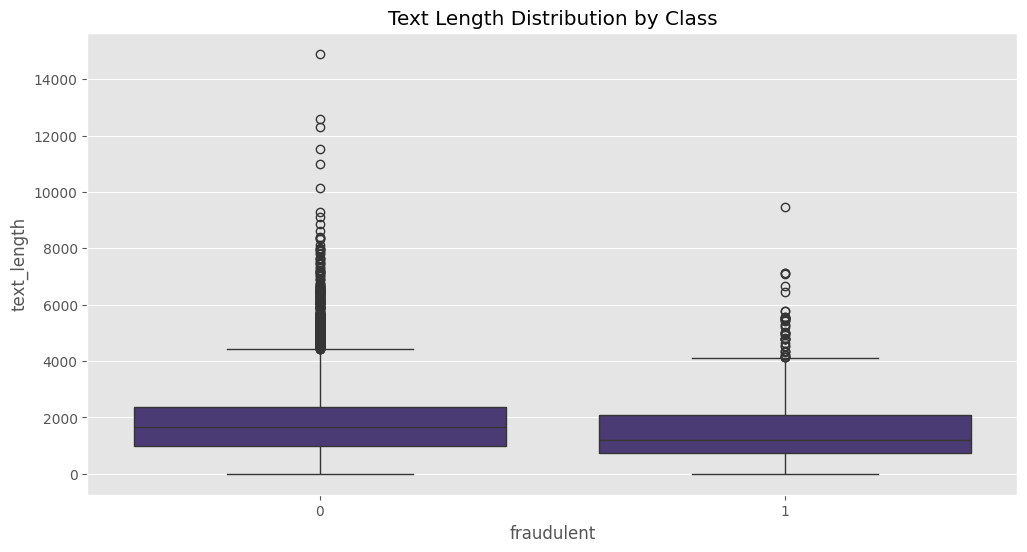

In [9]:
# Text Length Analysis
df['description'] = df['description'].fillna('')
df['requirements'] = df['requirements'].fillna('')
df['text'] = df['description'] + ' ' + df['requirements']
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,6))
sns.boxplot(x='fraudulent', y='text_length', data=df)
plt.title('Text Length Distribution by Class')
plt.show()

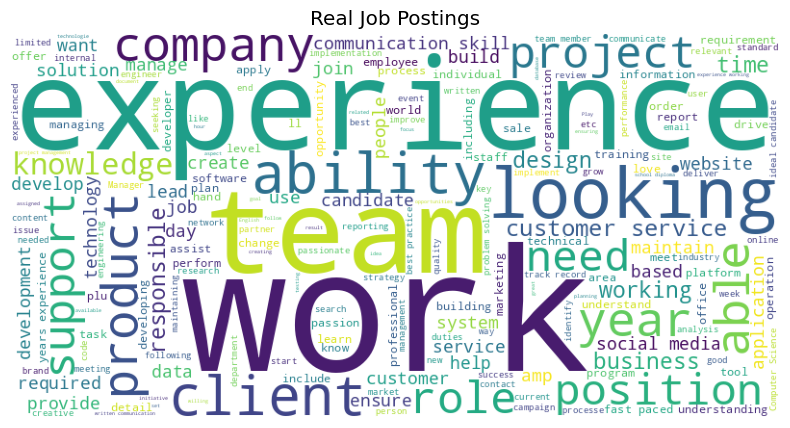

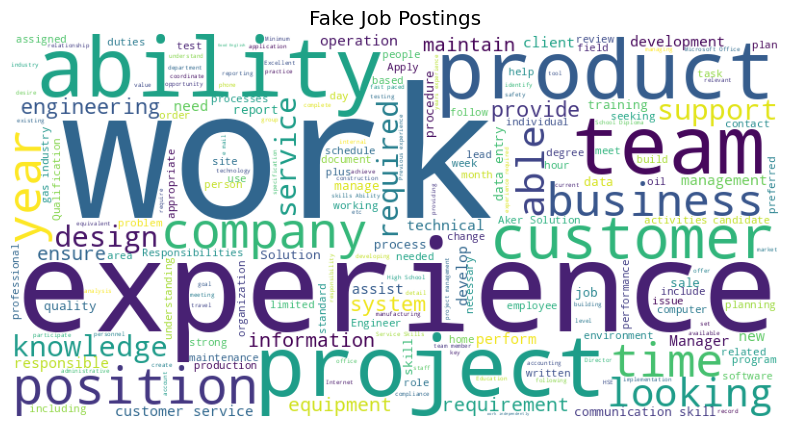

In [10]:
# Word Clouds
def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, 
                   background_color='white', 
                   stopwords=STOP_WORDS).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    plt.show()

real_text = ' '.join(df[df['fraudulent']==0]['text'].dropna())
fake_text = ' '.join(df[df['fraudulent']==1]['text'].dropna())
plot_wordcloud(real_text, 'Real Job Postings')
plot_wordcloud(fake_text, 'Fake Job Postings')

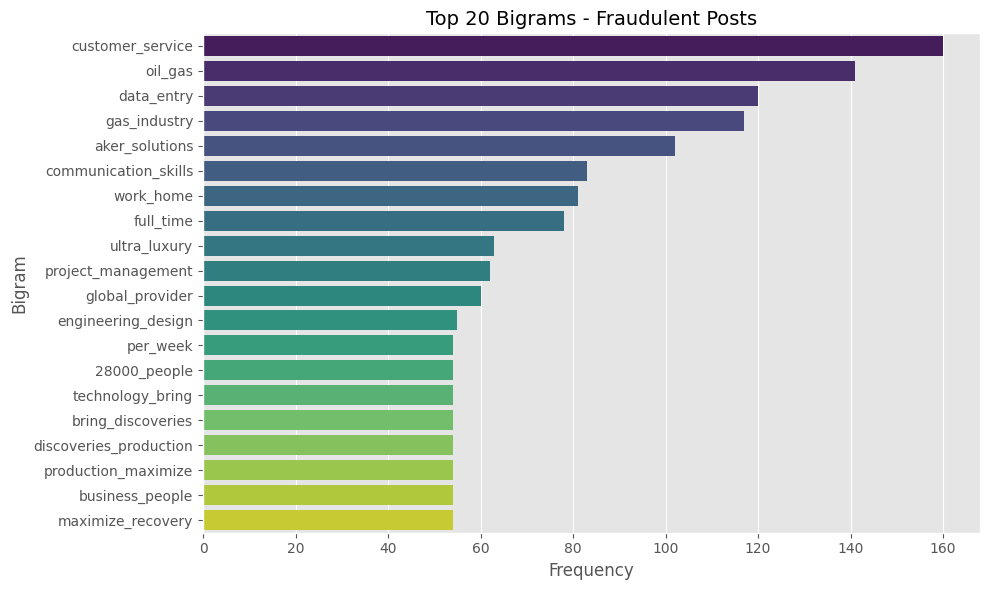

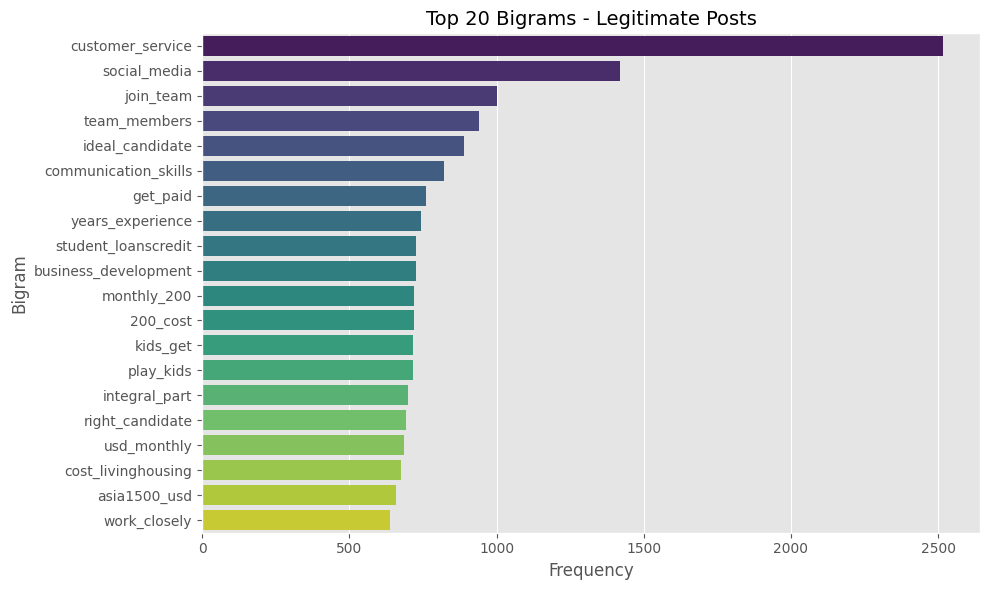

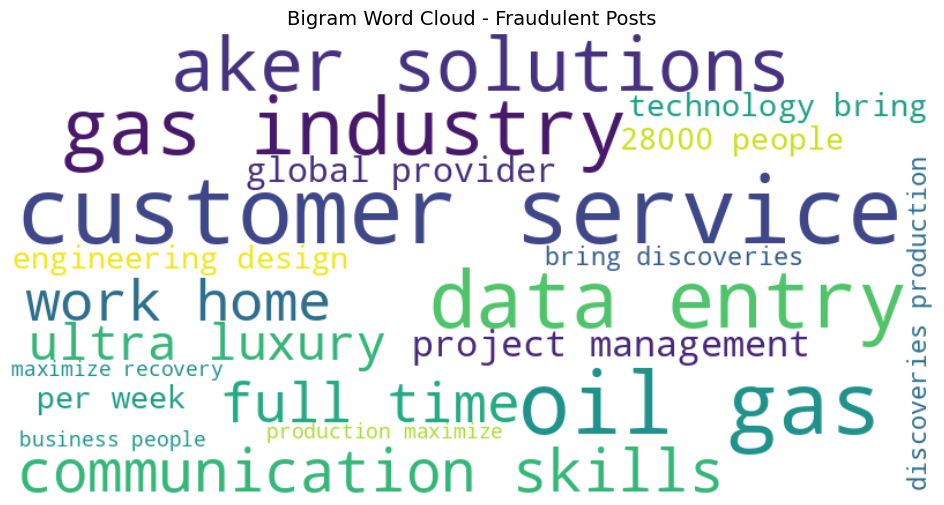

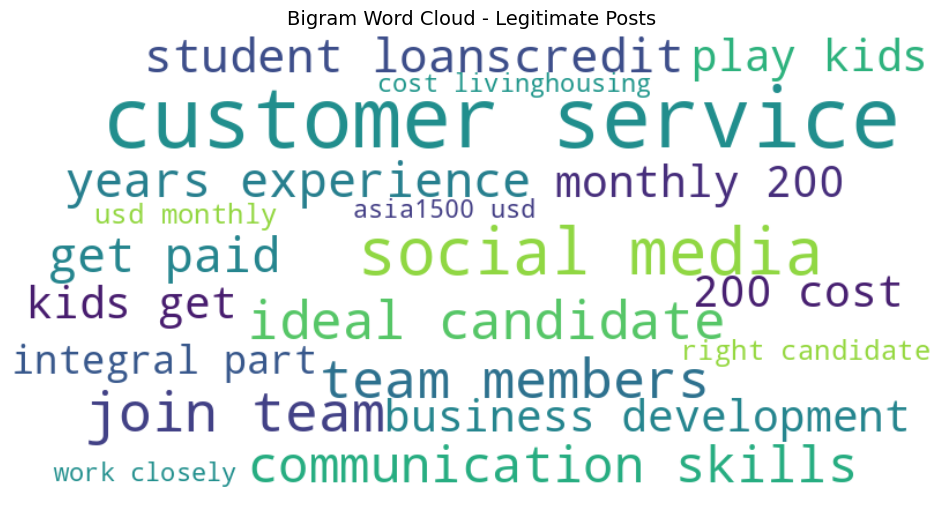

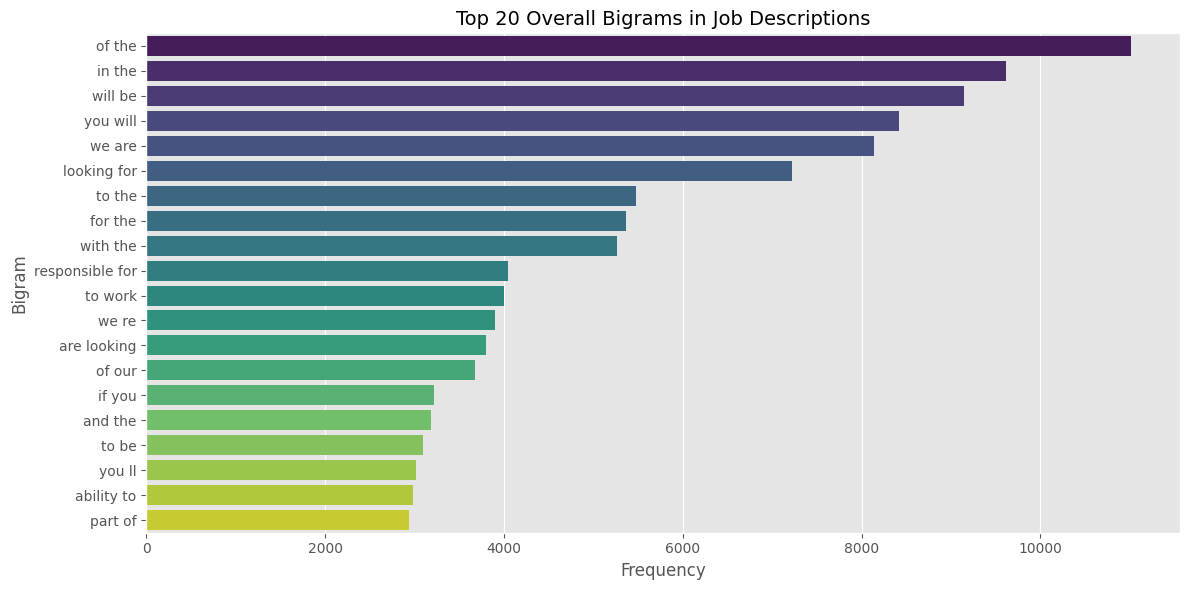

In [11]:
#%% Bigram Analysis Section

def preprocess_text(text):
    """Clean text data for n-gram analysis"""
    if pd.isna(text):
        return ''
    # Lowercase and remove punctuation
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', '', text)
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Apply preprocessing to job descriptions
df['clean_tokens'] = df['description'].apply(preprocess_text)

# Generate bigrams for each document
df['bigrams'] = df['clean_tokens'].apply(lambda x: list(nltk.bigrams(x)))

# Function to analyze bigrams by class
def analyze_bigrams_by_class(class_label):
    """Analyze bigram frequencies for a specific class"""
    all_bigrams = []
    for bg_list in df[df['fraudulent'] == class_label]['bigrams']:
        all_bigrams.extend(bg_list)
    bigram_freq = nltk.FreqDist(all_bigrams)
    return pd.DataFrame.from_dict(bigram_freq, orient='index', columns=['count']).sort_values('count', ascending=False)

# Get top bigrams for fraudulent and legitimate posts
fraud_bigrams = analyze_bigrams_by_class(1).head(20)
legit_bigrams = analyze_bigrams_by_class(0).head(20)

#%% Bigram Visualization

#%% Updated Bigram Visualization with Hue Assignment

def plot_bigram_freq(df_bigrams, title):
    """Plot top bigrams frequency distribution with proper hue handling"""
    plt.figure(figsize=(10,6))
    
    # Create formatted bigram strings
    df_plot = df_bigrams.reset_index()
    df_plot['bigram_str'] = df_plot['index'].map('_'.join)
    
    ax = sns.barplot(
        x='count', 
        y='bigram_str',
        hue='bigram_str',  # Assign hue to same variable as y
        data=df_plot,
        palette='viridis',
        legend=False  # Disable redundant legend
    )
    
    plt.title(f'Top 20 Bigrams - {title}', fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Bigram', fontsize=12)
    plt.tight_layout()
    plt.show()

# Generate visualizations
plot_bigram_freq(fraud_bigrams, 'Fraudulent Posts')
plot_bigram_freq(legit_bigrams, 'Legitimate Posts')


#%% Bigram Word Clouds

def generate_bigram_wordcloud(bigram_freq, title):
    """Generate word cloud from bigram frequencies"""
    bigram_dict = {' '.join(k): v for k, v in bigram_freq.to_dict()['count'].items()}
    
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          colormap='viridis').generate_from_frequencies(bigram_dict)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Bigram Word Cloud - {title}', fontsize=14)
    plt.axis('off')
    plt.show()

generate_bigram_wordcloud(fraud_bigrams, 'Fraudulent Posts')
generate_bigram_wordcloud(legit_bigrams, 'Legitimate Posts')

#%% Updated Advanced Bigram Analysis using CountVectorizer

# Create bigram vectorizer and transform data
bigram_vectorizer = CountVectorizer(ngram_range=(2,2), max_features=50)
bigram_matrix = bigram_vectorizer.fit_transform(df['description'].fillna(''))

# Prepare visualization data
bigram_counts = pd.DataFrame({
    'bigram': bigram_vectorizer.get_feature_names_out(),
    'count': np.asarray(bigram_matrix.sum(axis=0)).flatten()
}).sort_values('count', ascending=False).head(20)

# Plot overall bigram distribution with proper hue assignment
plt.figure(figsize=(12,6))
sns.barplot(
    x='count',
    y='bigram',
    hue='bigram',  # Assign hue to same variable as y
    data=bigram_counts,
    palette='viridis',
    legend=False  # Disable redundant legend
)
plt.title('Top 20 Overall Bigrams in Job Descriptions', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Bigram', fontsize=12)
plt.tight_layout()
plt.show()



In [12]:
#%% Data Preprocessing
# Handle Missing Values
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna(' ')
df['text'] = df[text_columns].apply(lambda x: ' '.join(x), axis=1)


In [13]:
# Text Cleaning Pipeline
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Lemmatization with SpaCy
def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Apply Cleaning
df['clean_text'] = df['text'].apply(clean_text).apply(lemmatize)


In [14]:
#%% Feature Engineering
# POS Tagging
def get_pos_tags(text):
    doc = nlp(text)
    return ' '.join([token.pos_ for token in doc])

df['pos_tags'] = df['clean_text'].apply(get_pos_tags)

# Text Length Features
df['char_count'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))



In [15]:
#%% Handle Class Imbalance
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df[['clean_text', 'pos_tags', 'char_count', 'word_count']], 
                                df['fraudulent'])

In [16]:
#%% Prepare Data for Modeling
# Combine Features
X = X_res['clean_text'] + ' ' + X_res['pos_tags']
y = y_res

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)


In [17]:
#%% Model Building Pipeline
models = [
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('SVC', SVC(class_weight='balanced')),
    ('RF', RandomForestClassifier(class_weight='balanced')),
    ('NB', MultinomialNB())
]

results = []
for name, model in models:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
        ('clf', model)
    ])
    
    # Cross-Validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    
    # Full Training
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Store Results
    results.append({
        'Model': name,
        'CV Mean F1': np.mean(cv_scores),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Test Recall': recall_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred)
    })


Model Performance Comparison:


,CV Mean F1,Test Accuracy,Test Precision,Test Recall,Test F1,ROC AUC
Model,,,,,,
RF,0.999046,1.000000,1.000000,1.000000,1.000000,1.000000
SVC,0.993924,0.997061,0.996187,0.997943,0.997064,0.997061
LogReg,0.955680,0.965325,0.959119,0.972083,0.965558,0.965325
NB,0.900372,0.915369,0.947735,0.879224,0.912195,0.915369



Best Model: RF


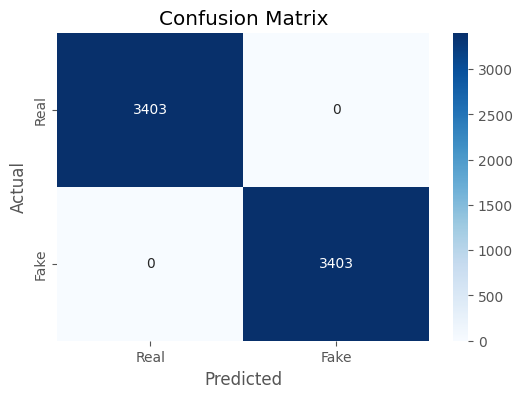


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       1.00      1.00      1.00      3403

    accuracy                           1.00      6806
   macro avg       1.00      1.00      1.00      6806
weighted avg       1.00      1.00      1.00      6806



In [21]:
#%% Model Evaluation
results_df = pd.DataFrame(results).set_index('Model')
print("\nModel Performance Comparison:")
display(results_df.sort_values('Test F1', ascending=False))


model_classes = {
    'RF': RandomForestClassifier,
    'SVM': SVC,
    'LR': LogisticRegression,
    'NB': MultinomialNB
}

# Best Model Pipeline
best_model_name = results_df['Test F1'].idxmax()
print(f"\nBest Model: {best_model_name}")
best_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
    ('clf', model_classes[best_model_name]())  # Use the mapping here
])

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

GloVe (Global Vectors for Word Representation) is a foundational method in natural language processing that generates word embeddings by analyzing global word co-occurrence patterns across a corpus.

Neural networks leverage GloVe embeddings as input features to enhance performance in tasks like text classification and sentiment analysis. 

In [22]:
"""Load the Glove vectors in a dictionary"""
embeddings_index={}
with open('glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embeddings_index[word]=vectors
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
""" Function Creates a normalized vector for the whole sentence"""
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(200)
    return v / np.sqrt((v ** 2).sum())

In [24]:
# create glove features
from tqdm import tqdm
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
nltk.download('punkt_tab')
xtrain_glove = np.array([sent2vec(x) for x in tqdm(X_train, position=0, leave=True, desc="Processing Train Set")])
xtest_glove = np.array([sent2vec(x) for x in tqdm(X_test, position=0, leave=True, desc="Processing Test Set")])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/shashnavad/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Processing Test Set: 100%|█████████████████| 6806/6806 [00:20<00:00, 336.10it/s]


In [25]:
"""scale the data before any neural net"""
from sklearn import preprocessing
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xtest_glove_scl = scl.transform(xtest_glove)

In [26]:
"""create a simple 2 layer sequential neural net"""
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Embedding, GRU
from keras.layers import BatchNormalization

model = Sequential()

model.add(Dense(200, input_dim=200, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.fit(xtrain_glove_scl, y=y_train, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xtest_glove_scl, y_test))

Epoch 1/10
426/426 [==============================] - 2s 2ms/step - loss: 0.3290 - accuracy: 0.8570 - val_loss: 0.1373 - val_accuracy: 0.9534
Epoch 2/10
426/426 [==============================] - 1s 2ms/step - loss: 0.1684 - accuracy: 0.9361 - val_loss: 0.0766 - val_accuracy: 0.9753
Epoch 3/10
426/426 [==============================] - 1s 2ms/step - loss: 0.1182 - accuracy: 0.9559 - val_loss: 0.0642 - val_accuracy: 0.9788
Epoch 4/10
426/426 [==============================] - 1s 2ms/step - loss: 0.0938 - accuracy: 0.9660 - val_loss: 0.0387 - val_accuracy: 0.9903
Epoch 5/10
426/426 [==============================] - 1s 2ms/step - loss: 0.0801 - accuracy: 0.9716 - val_loss: 0.0335 - val_accuracy: 0.9897
Epoch 6/10
426/426 [==============================] - 1s 2ms/step - loss: 0.0645 - accuracy: 0.9773 - val_loss: 0.0415 - val_accuracy: 0.9866
Epoch 7/10
426/426 [==============================] - 1s 2ms/step - loss: 0.0547 - accuracy: 0.9805 - val_loss: 0.0258 - val_accuracy: 0.9918
Epoch 

In [28]:
predictions = model.predict(xtest_glove_scl)
predictions = np.round(predictions).astype(int)
print('2 layer sequential neural net on GloVe Feature')
print ("AUC score :", np.round(roc_auc_score(y_test, predictions),5))

213/213 [==============================] - 0s 554us/step
2 layer sequential neural net on GloVe Feature
AUC score : 0.99354


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               500100    
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 10)                260       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 506696 (1.93 MB)
Trainable params: 506696 (1.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
851/851 

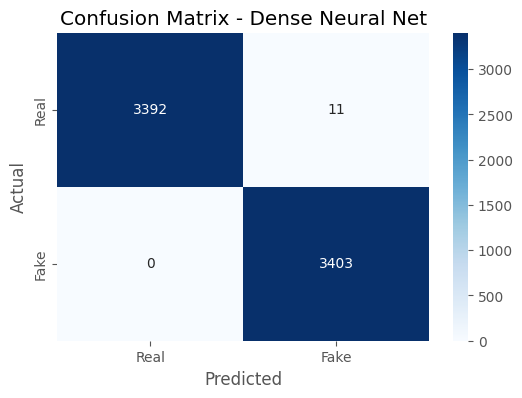

In [29]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  # ✅ Fix here

# Use TfidfVectorizer to extract features again
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_vectorized = vectorizer.fit_transform(X_train)

# Define model
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=X_vectorized.shape[1]))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train
model.fit(X_vectorized.toarray(), y_train, epochs=5, batch_size=32)

# Transform test data using the same TF-IDF vectorizer
X_test_vectorized = vectorizer.transform(X_test)

# Predict
pred_cv = model.predict(X_test_vectorized.toarray())
pred_cv = np.around(pred_cv, decimals=0)

# Evaluation
print("Accuracy:", accuracy_score(y_test, pred_cv))
print("\nClassification Report:\n", classification_report(y_test, pred_cv))

# Confusion Matrix
cm = confusion_matrix(y_test, pred_cv)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix - Dense Neural Net')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()